# <center> MRI Segmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# импортируем требуемые бибилиотеки

import torch
from source.network import NNSegmentation
from source.helpme import show_history, show_image, calculate_pad, load_mri
import numpy as np
import torchvision
import os
from torchvision import transforms
from sklearn.model_selection import train_test_split
import glob

In [3]:
to_images = '/Users/timur89833239972/Desktop/Campus 2.0/data/norm_hydro/train/images'
to_masks = '/Users/timur89833239972/Desktop/Campus 2.0/data/norm_hydro/train/masks'

to_images = glob.glob(os.path.join(to_images, '*'))
to_masks = glob.glob(os.path.join(to_masks, '*'))

In [4]:
X, y = load_mri('/Users/timur89833239972/Desktop/Campus 2.0/data/norm_hydro/train/', 
                size=(128, 128))

In [5]:
X.shape, y.shape

((192, 1, 128, 128), (192, 128, 128))

In [6]:
X[0].max(), y[0].max()

(1.0, 1.0)

In [7]:
y = (y == 1).astype(int)

## U-net

In [8]:
from torchsummary import summary
import matplotlib.pyplot as plt

In [9]:
# определим архитектуру сети

unet = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, 
                                               out_channels=16, 
                                               kernel_size=3, 
                                               stride=2, 
                                               padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(16),
                               # 64x64

                               torch.nn.Conv2d(16, 32, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(32),
                               # 32x32
                               
                               
                               torch.nn.MaxPool2d(kernel_size=3, 
                                                  stride=2, 
                                                  padding=1),
                               # 16x16

                               torch.nn.Conv2d(32, 64, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(64),
                               # 8x8

                               torch.nn.Conv2d(64, 128, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(128),
                               # 4x4

                               # далее обратно увеличиваем spatial size
                               torch.nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(128),
                               # 8x8
                           
                               torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(64),
                               # 16x16
                           
                               torch.nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(64),
                               # 32x32
                           
                               torch.nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(64),
                               # 64x64
                           
                               torch.nn.ConvTranspose2d(64, 2, 4, stride=2, padding=1),
                               # 128x128
                          )

In [10]:
# summary(unet, (1, 128, 128))

In [11]:
# определим модель с удобным функционалом

model = NNSegmentation(unet, lr=5e-4)

In [12]:
model.fit(X, y, epochs=25, batch_size=16)

A Jupyter Widget

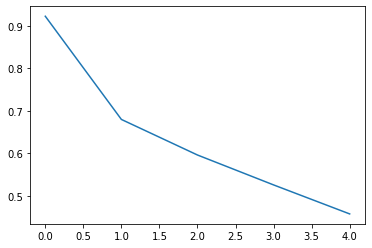

In [13]:
plt.plot(model.train_history)

In [14]:
masks_pred = model.predict(X[:10])

In [15]:
masks_pred.shape

(10, 2, 128, 128)

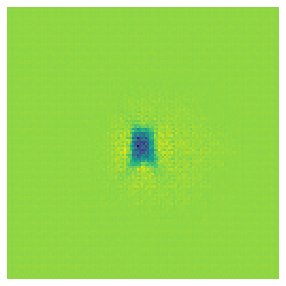

In [18]:
show_image(masks_pred[8][0])

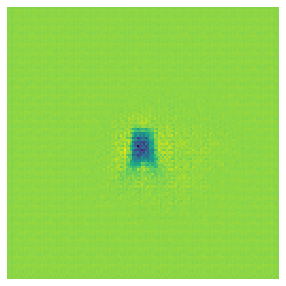

In [20]:
show_image(masks_pred[2][0])